In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [2]:
# ===================================================================
# Part 1: 设置与导入
# ===================================================================
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import timm

print("1")

/environment/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


In [3]:
# --- 核心配置区 ---
MODEL_CONFIG = {
    'model_name': 'ConvNeXt-XL', # <--- 目标模型: ConvNeXt-Large
    'batch_size': 16,      # ConvNeXt-L模型很大，建议从较小的batch_size开始，如16或24
    'learning_rate': 1e-4,
    'num_epochs':30,
    'warmup_epochs':5,
}

# 基本设置
student_id = '22211360121'
subdir = ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}, 正在配置模型: {MODEL_CONFIG['model_name']}")



使用的设备: cuda, 正在配置模型: ConvNeXt-XL


In [4]:
# ===================================================================
# Part 2: 训练 ConvNeXt-Large 模型
# ===================================================================

# --- 2.1 数据预处理 ---
print(f"\n--- 正在为 {MODEL_CONFIG['model_name']} 准备数据和变换 ---")

# 使用 timm 提供的标准预处理
model_official_transforms = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
print(f"{MODEL_CONFIG['model_name']} 官方推荐的预处理流程:")
print(model_official_transforms)

# 定义包含高级数据增强的训练集变换
from torchvision.transforms import RandAugment
train_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.6, scale=(0.02, 0.33)),
])
# 验证集和测试集使用官方标准变换
val_test_transform = model_official_transforms

# --- 2.2 数据加载 ---
full_train_dataset = torchvision.datasets.ImageFolder(root='new data/train')
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform
train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
class_names = full_train_dataset.classes
print(f"\n训练集大小: {len(train_subset)}, 验证集大小: {len(val_subset)}")


# --- 2.3 模型定义、优化器与调度器 ---
# 使用 timm 加载 ConvNeXt-XL 模型（预训练）
model = timm.create_model('convnext_xlarge', pretrained=True)
# 替换最后的分类头
num_ftrs = model.head.in_features
model.head.fc= nn.Linear(num_ftrs, len(class_names))
model.to(device)

class FocalLossWithSmoothing(nn.Module):
    def __init__(self, alpha=1, gamma=2, smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = nn.functional.log_softmax(input, dim=-1)
        probs = torch.exp(log_probs)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)) ** self.gamma
        loss = self.alpha * focal_weight * nll_loss
        return loss.mean()

criterion = FocalLossWithSmoothing()


optimizer = optim.AdamW(model.parameters(), lr=MODEL_CONFIG['learning_rate'], weight_decay=0.01)

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

# 初始化AMP梯度缩放器
scaler = torch.cuda.amp.GradScaler()


# --- 2.4 训练与验证循环 (集成AMP) ---
model_save_path = f"f2.pth" # <--- 修改保存路径
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 7
train_loss_history, val_loss_history, val_acc_history = [], [], []



--- 正在为 ConvNeXt-XL 准备数据和变换 ---
ConvNeXt-XL 官方推荐的预处理流程:
Compose(
    Resize(size=384, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

训练集大小: 3199, 验证集大小: 356


In [5]:
print(f"\n--- 开始为 {MODEL_CONFIG['model_name']} 进行实际训练 ---")

for epoch in range(MODEL_CONFIG['num_epochs']):
    model.train()
    total_train_loss = 0
    train_bar = tqdm(train_loader, desc=f'训练轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.1e}'})
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    total_val_loss, total_val_correct = 0, 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'验证轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / len(val_loader.dataset)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    
    print(f'\n轮次 {epoch+1} | 训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | 验证准确率: {val_accuracy:.4f}')
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'验证损失下降。保存最佳模型到 {model_save_path}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stop_patience:
        print(f'在 {epoch+1} 轮后触发早停机制。')
        break

print(f"\n--- {MODEL_CONFIG['model_name']} 训练完成！权重已保存至 {model_save_path} ---")


--- 开始为 ConvNeXt-XL 进行实际训练 ---


验证轮次 1/30: 100%|██████████| 23/23 [00:01<00:00, 12.17it/s]



轮次 1 | 训练损失: 1.2936 | 验证损失: 0.2378 | 验证准确率: 0.9045
验证损失下降。保存最佳模型到 f2.pth


验证轮次 2/30: 100%|██████████| 23/23 [00:01<00:00, 11.58it/s]



轮次 2 | 训练损失: 0.1302 | 验证损失: 0.2182 | 验证准确率: 0.9101
验证损失下降。保存最佳模型到 f2.pth


验证轮次 3/30: 100%|██████████| 23/23 [00:01<00:00, 11.86it/s]



轮次 3 | 训练损失: 0.0336 | 验证损失: 0.1885 | 验证准确率: 0.9185
验证损失下降。保存最佳模型到 f2.pth


验证轮次 4/30: 100%|██████████| 23/23 [00:01<00:00, 11.64it/s]



轮次 4 | 训练损失: 0.0080 | 验证损失: 0.1536 | 验证准确率: 0.9438
验证损失下降。保存最佳模型到 f2.pth


验证轮次 5/30: 100%|██████████| 23/23 [00:01<00:00, 12.05it/s]



轮次 5 | 训练损失: 0.0065 | 验证损失: 0.1793 | 验证准确率: 0.9382


验证轮次 6/30: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



轮次 6 | 训练损失: 0.0064 | 验证损失: 0.2528 | 验证准确率: 0.9157


验证轮次 7/30: 100%|██████████| 23/23 [00:01<00:00, 11.76it/s]



轮次 7 | 训练损失: 0.0051 | 验证损失: 0.2012 | 验证准确率: 0.9298


验证轮次 8/30: 100%|██████████| 23/23 [00:01<00:00, 11.95it/s]



轮次 8 | 训练损失: 0.0006 | 验证损失: 0.1694 | 验证准确率: 0.9410


验证轮次 9/30: 100%|██████████| 23/23 [00:01<00:00, 12.15it/s]



轮次 9 | 训练损失: 0.0002 | 验证损失: 0.1666 | 验证准确率: 0.9354


验证轮次 10/30: 100%|██████████| 23/23 [00:01<00:00, 11.87it/s]



轮次 10 | 训练损失: 0.0001 | 验证损失: 0.1663 | 验证准确率: 0.9382


验证轮次 11/30: 100%|██████████| 23/23 [00:01<00:00, 11.82it/s]


轮次 11 | 训练损失: 0.0001 | 验证损失: 0.1662 | 验证准确率: 0.9382
在 11 轮后触发早停机制。

--- ConvNeXt-XL 训练完成！权重已保存至 f2.pth ---


In [6]:
# ===================================================================
# Part 3: 预测与可视化
# ===================================================================
print(f"\n--- 开始使用 {MODEL_CONFIG['model_name']} 最佳模型进行预测 ---")

# --- 3.1 加载模型 ---
# 创建一个与保存的模型结构相同的空模型
# 创建一个空模型，并修改结构
model = timm.create_model('convnext_xlarge', pretrained=False)
num_ftrs = model.head.fc.in_features
model.head.fc = nn.Linear(num_ftrs, len(class_names))

# 加载权重
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()

# --- 3.2 预测 (带TTA) ---
transform = val_test_transform # 使用标准的验证/测试变换
test_folder = 'new data/testB'
test_images = [img for img in os.listdir(test_folder) if img.endswith('.jpg')]
predicts = []
idx = []

with torch.no_grad():
    for img_name in tqdm(test_images, desc=f'使用 {MODEL_CONFIG["model_name"]} 和 TTA 进行预测'):
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        images_tta = [
            transform(image),
            transform(transforms.functional.hflip(image)),
            transform(transforms.functional.rotate(image, 15)),
            transform(transforms.functional.rotate(image, -15))
        ]
        batch_tta = torch.stack(images_tta).to(device)
        
        with torch.cuda.amp.autocast():
             outputs_tta = model(batch_tta)

        probs_tta = torch.softmax(outputs_tta, dim=1)
        avg_probs = torch.mean(probs_tta, dim=0)
        _, predicted = torch.max(avg_probs, 0)
        
        predicts.append(predicted.item())
        idx.append(img_name.replace('.jpg', ''))

# --- 3.3 保存结果 ---
submission = pd.DataFrame({'id': idx, 'label': predicts})
submission['id'] = submission['id'].astype(int)
submission = submission.sort_values(by='id')
submission_filename = f"{student_id}_submission_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission.to_csv(submission_filename, index=False)
print(f"预测完成，结果已保存到 {submission_filename}！")



--- 开始使用 ConvNeXt-XL 最佳模型进行预测 ---


使用 ConvNeXt-XL 和 TTA 进行预测: 100%|██████████| 1244/1244 [00:43<00:00, 28.55it/s]

预测完成，结果已保存到 22211360121_submission_20250612_192150.csv！


/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35777 (\N{CJK UNIFIE


--- 开始生成可视化图表 ---


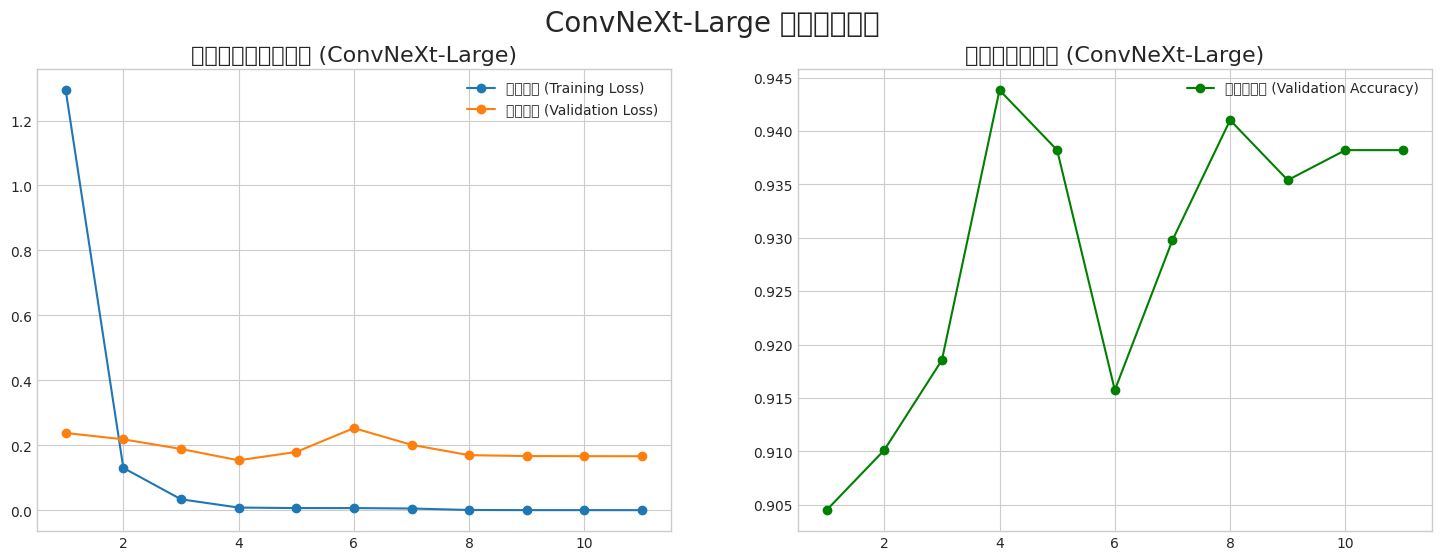

In [7]:
# --- 3.4 可视化 ---
print("\n--- 开始生成可视化图表 ---")
num_actual_epochs = len(train_loss_history)
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(range(1, num_actual_epochs + 1), train_loss_history, 'o-', label='训练损失 (Training Loss)')
ax1.plot(range(1, num_actual_epochs + 1), val_loss_history, 'o-', label='验证损失 (Validation Loss)')
ax1.set_title('训练与验证损失曲线 (ConvNeXt-Large)', fontsize=16)
ax1.legend()

ax2.plot(range(1, num_actual_epochs + 1), val_acc_history, 'o-', label='验证准确率 (Validation Accuracy)', color='g')
ax2.set_title('验证准确率曲线 (ConvNeXt-Large)', fontsize=16)
ax2.legend()

plt.suptitle('ConvNeXt-Large 训练过程监控', fontsize=20)
plt.show()